# Neural Network from scratch

In [180]:
from typing import List
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class NeuralNetwork:
    """
    creates a fully connected network given the number of neurons in each layer.
    """

    def __init__(self, n_input_neurons: int, layer_neurons_count: List[int], cost, lr) -> None:
        self.__lr = lr
        self.__weights = []
        self.__biases = []
        self.__n_layers = len(layer_neurons_count)
        self.__n_input_neurons = n_input_neurons
        layer_neurons_count = [n_input_neurons] + layer_neurons_count
        for i in range(1, len(layer_neurons_count)):
            self.__weights.append(np.ones((layer_neurons_count[i - 1], layer_neurons_count[i])))
            self.__biases.append(np.ones((layer_neurons_count[i], 1)))

        self.__sigfunc = np.vectorize(self.__sigmoid)
        self.__dsigfunc = np.vectorize(self.__dsigmoid)
        assert len(self.__weights) == len(self.__biases) == self.__n_layers, "n_layers should match weights and biases"

        if cost == "mse":
            self.__cost = self.__mse_cost
            self.__dcost = self.__d_mse_cost
        elif cost == "bce":
            self.__cost = self.__bce_cost
            self.__dcost = self.__d_bce_cost
        else:
            raise Exception("invalid cost")
        
        self.__costs = []

    def __mse_cost(self, y_pred, y_actual):
        return np.power((y_pred - y_actual), 2)

    def __d_mse_cost(self, y_pred, y_actual):
        return 2 * (y_pred - y_actual)

    def __bce_cost(self, y_pred, y_actual):
        return -np.mean(y_actual * np.log(y_pred) + (1 - y_actual) * np.log(1 - y_pred))

    def __d_bce_cost(self, y_pred, y_actual):
        return -(y_actual / y_pred) + (1 - y_actual) / (1 - y_pred)

    def __sigmoid(self, x):
        return 1 / (1 + np.e**(-x))

    def __dsigmoid(self, x):
        return self.__sigmoid(x) * (1 - self.__sigmoid(x))

    def __forward_pass(self, x):
        assert x.shape[0] == self.__weights[0].shape[0], "input shape does not match weights shape"
        
        self.__zs = []
        self.__outputs = [x]
        o = x
        for i in range(self.__n_layers):
            w = self.__weights[i]
            b = self.__biases[i]
            z = w.T @ o + b
            self.__zs.append(z)
            o = self.__sigfunc(z)
            self.__outputs.append(o)

        assert len(self.__outputs) == self.__n_layers + 1, "outputs should be 1 more than n_layers"

        return self.__outputs[-1]

    def __backward_pass(self, x, y, y_pred):
        cost = self.__cost(y_pred=y_pred, y_actual=y)
        self.__costs.append(cost)

        z = self.__zs[-1]

        # delta == dC/dz == dC/da * da/dz
        delta = np.multiply(self.__dcost(y_pred=y_pred, y_actual=y), self.__dsigmoid(z)) 
        for i in range(self.__n_layers-1, -1, -1):
            delta_b = delta
            self.__biases[i] -= self.__lr * delta_b

            o_1 = self.__outputs[i]
            delta_w = o_1 @ delta.T
            self.__weights[i] -= self.__lr * delta_w

            if i == 0:
                break # finished, can not calculate delta_0

            delta = np.multiply(self.__weights[i] @ delta, self.__dsigfunc(self.__zs[i-1])) 
        

    def fit(self, X_train, y_train, n_epochs):
        assert len(X_train) == len(y_train), "X and y lengths must be equal"

        X_train = self.__convert_X_to_np_array(X_train)
        y_train = np.array(y_train)

        if X_train.shape[1] != self.__n_input_neurons:
            raise Exception("input dim does not match n_input_neurons")
            
        for i in tqdm(range(n_epochs), desc=f"Training:"):
            for (x, y) in zip(X_train, y_train):
                y_pred = self.__forward_pass(x)
                self.__backward_pass(x, y, y_pred)

    def predict(self, x):
        prob = self.predict_proba(x)
        return round(prob[0][0])

    def predict_proba(self, x):
        return self.__forward_pass(x)

    def __convert_X_to_np_array(self, arr):
        arr = np.array(arr)
        assert len(arr.shape) == 2, "X should be a list of lists"

        for i in range(len(arr)):
            arr[i] = np.array(arr[i])

        return arr.reshape(arr.shape[0], arr.shape[1], 1)
        
    def history(self):
        history = {
            "hyper_params": {
                "learning_rate": self.__lr,
                "weights": self.__weights,
                "biases": self.__biases,
            },
            "costs": self.__costs,
        }

        return history

In [226]:
model = NeuralNetwork(n_input_neurons=2, layer_neurons_count=[2,1], cost="bce", lr=0.01)

X_train = [[0, 0], [0, 1], [1, 0], [1, 1]]
y_train = [0, 1, 1, 0]


model.fit(X_train=X_train, y_train=y_train, n_epochs=1000)
hist = model.history()

Training:: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4889.83it/s]


In [227]:
for x, y in zip(X_train, y_train):
    x = np.array(x).reshape(2, 1)
    print(x, "-->", model.predict(np.array(x)), "should be:", y)

[[0]
 [0]] --> 0 should be: 0
[[0]
 [1]] --> 1 should be: 1
[[1]
 [0]] --> 1 should be: 1
[[1]
 [1]] --> 1 should be: 0


## Plot the costs

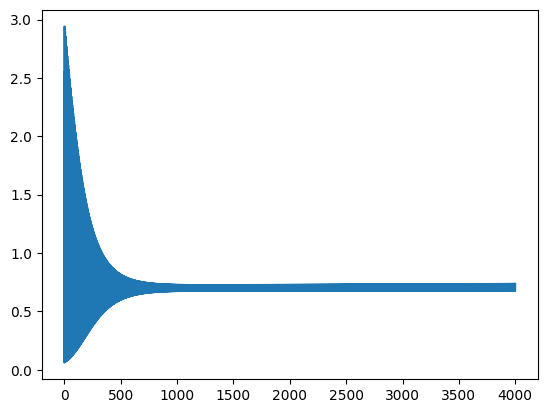

In [228]:
plt.plot(range(len(hist["costs"])), hist["costs"])

## Test vs TensorFlow

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

x = [[0, 0], [0, 1], [1, 0], [1, 1]]
y = [[0], [1], [1], [0]]

model = Sequential()

model.add(Dense(units=2, input_dim=2, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

h = model.fit(x, y, epochs=1000, verbose=0)

loss, accuracy = model.evaluate(x, y)
print(f'Loss: {loss}, Accuracy: {accuracy}')

predictions = model.predict(x)
print('XOR predictions:')
for i, prediction in enumerate(predictions):
    print(f'{x[i]} => {prediction[0]:.5f} (rounded: {int(round(prediction[0]))})')

1/1 [==============================] - 0s 35ms/step - loss: 0.4874 - accuracy: 0.7500
Loss: 0.4873509109020233, Accuracy: 0.75
1/1 [==============================] - 0s 19ms/step
XOR predictions:
[0, 0] => 0.34610 (rounded: 0)
[0, 1] => 0.96197 (rounded: 1)
[1, 0] => 0.34610 (rounded: 0)
[1, 1] => 0.34610 (rounded: 0)


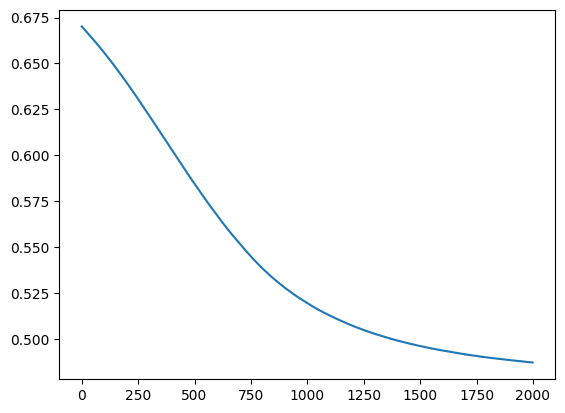

In [138]:
plt.plot(range(len(h.history["loss"])), h.history["loss"])

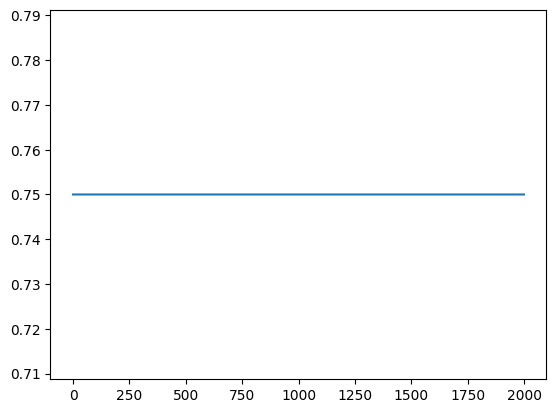

In [139]:
plt.plot(range(len(h.history["accuracy"])), h.history["accuracy"])

## More params in TF

In [208]:
x = [[0, 0], [0, 1], [1, 0], [1, 1]]
y = [[0], [1], [1], [0]]

model = Sequential()

model.add(Dense(units=20, input_dim=2, activation='relu'))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

h = model.fit(x, y, epochs=200, verbose=0)

loss, accuracy = model.evaluate(x, y)
print(f'Loss: {loss}, Accuracy: {accuracy}')

predictions = model.predict(x)
print('XOR predictions:')
for i, prediction in enumerate(predictions):
    print(f'{x[i]} => {prediction[0]:.5f} (rounded: {int(round(prediction[0]))})')

1/1 [==============================] - 0s 37ms/step - loss: 0.3356 - accuracy: 1.0000
Loss: 0.33561259508132935, Accuracy: 1.0
1/1 [==============================] - 0s 20ms/step
XOR predictions:
[0, 0] => 0.37348 (rounded: 0)
[0, 1] => 0.68547 (rounded: 1)
[1, 0] => 0.90910 (rounded: 1)
[1, 1] => 0.33098 (rounded: 0)


# Faces classifier

In [237]:
!ls

env                  neural_network.ipynb
faces                requirements.txt


In [244]:
import glob

paths = glob.glob("./faces/*")

In [293]:
from PIL import Image

def extract_data(name):
    return name.split("_")

X = []
name = []
pose = []
mood = []
eyes = []
    
for p in paths:
    img = Image.open(p)
    img = np.array(img)
    X.append(img)
    
    filename = p.removeprefix("./faces/")
    filename = filename.removesuffix("_4.pgm")
    data = extract_data(filename)
    name.append(data[0])
    pose.append(data[1])
    mood.append(data[2])
    eyes.append(data[3])

X = np.array(X)
name = np.array(name)
pose = np.array(pose)
mood = np.array(mood)
eyes = np.array(eyes)

In [294]:
print(np.min(X), np.max(X))
X.shape, name.shape, pose.shape, mood.shape, eyes.shape

0 252


((624, 30, 32), (624,), (624,), (624,), (624,))

## Eyes

In [390]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(eyes)

In [391]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X_normalized = X / 255.0
num_classes = len(set(y))
y_categorical = to_categorical(y, num_classes)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_categorical, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = Sequential([
    Flatten(input_shape=(30, 32)), 
    Dense(128, activation='relu'), 
    Dense(num_classes, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train, y_train, validation_data=[X_val, y_val], 
                 workers=-1, use_multiprocessing=True, epochs=300, verbose=0)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

2/2 [==============================] - 0s 1ms/step - loss: 0.0480 - accuracy: 0.9683
Loss: 0.048029471188783646, Accuracy: 0.9682539701461792


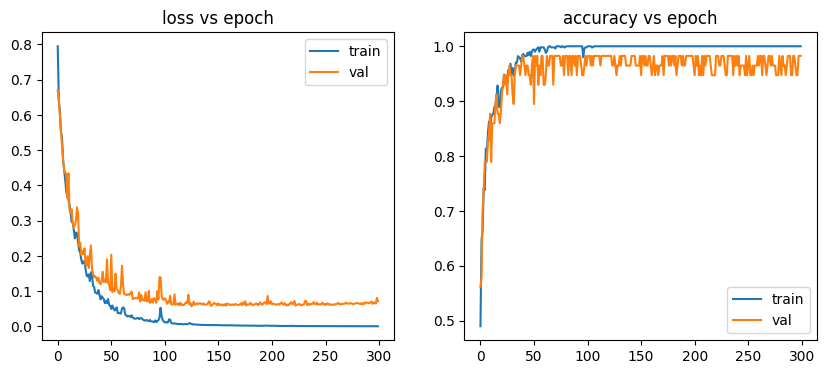

In [392]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(len(hist.history["loss"])), hist.history["loss"], label="train")
plt.plot(range(len(hist.history["val_loss"])), hist.history["val_loss"], label="val")
plt.title("loss vs epoch")
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(len(hist.history["accuracy"])), hist.history["accuracy"], label="train")
plt.plot(range(len(hist.history["val_accuracy"])), hist.history["val_accuracy"], label="val")
plt.title("accuracy vs epoch")
plt.legend()
plt.show()

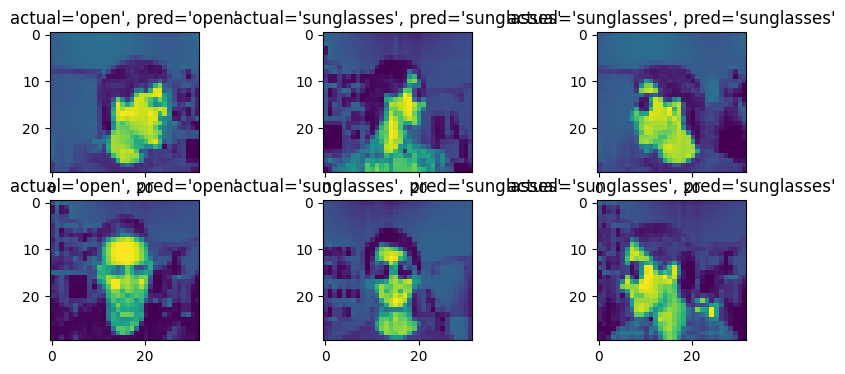

In [393]:
from random import sample
import math

plt.figure(figsize=(10, 4))
n_examples = 6
examples = sample(range(len(X_test)), k=n_examples)
for i in range(n_examples):
    x = X_test[i]
    y_actual = y_test[i]
    y_pred = model.predict(X_test[i].reshape(1, 30, 32), verbose=0)
    actual = le.inverse_transform([np.argmax(y_actual)])[0]
    pred = le.inverse_transform([np.argmax(y_pred)])[0]
    plt.subplot(2, math.ceil(n_examples/2), i+1)
    plt.imshow(x)
    plt.title(f"{actual=}, {pred=}")

plt.show()

## Pose

In [394]:
le = LabelEncoder()
y = le.fit_transform(pose)

X_normalized = X / 255.0
num_classes = len(set(y))
y_categorical = to_categorical(y, num_classes)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_categorical, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = Sequential([
    Flatten(input_shape=(30, 32)), 
    Dense(128, activation='relu'), 
    Dense(num_classes, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train, y_train, validation_data=[X_val, y_val], 
                 workers=-1, use_multiprocessing=True, epochs=300, verbose=0)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

2/2 [==============================] - 0s 1ms/step - loss: 0.0708 - accuracy: 0.9683
Loss: 0.07077277451753616, Accuracy: 0.9682539701461792


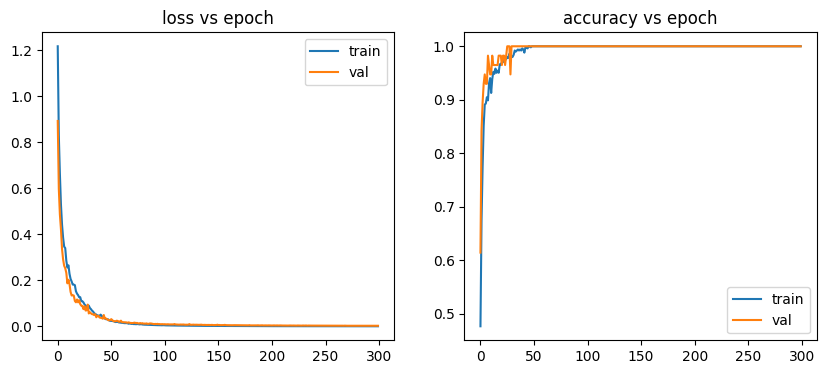

In [395]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(len(hist.history["loss"])), hist.history["loss"], label="train")
plt.plot(range(len(hist.history["val_loss"])), hist.history["val_loss"], label="val")
plt.title("loss vs epoch")
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(len(hist.history["accuracy"])), hist.history["accuracy"], label="train")
plt.plot(range(len(hist.history["val_accuracy"])), hist.history["val_accuracy"], label="val")
plt.title("accuracy vs epoch")
plt.legend()
plt.show()

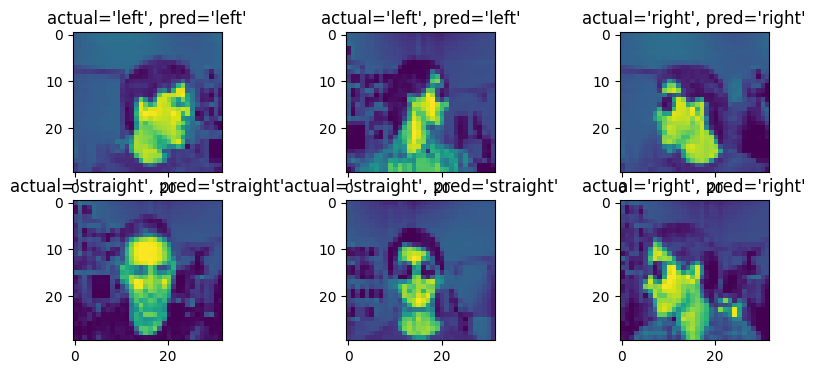

In [396]:
from random import sample
import math

plt.figure(figsize=(10, 4))
n_examples = 6
examples = sample(range(len(X_test)), k=n_examples)
for i in range(n_examples):
    x = X_test[i]
    y_actual = y_test[i]
    y_pred = model.predict(X_test[i].reshape(1, 30, 32), verbose=0)
    actual = le.inverse_transform([np.argmax(y_actual)])[0]
    pred = le.inverse_transform([np.argmax(y_pred)])[0]
    plt.subplot(2, math.ceil(n_examples/2), i+1)
    plt.imshow(x)
    plt.title(f"{actual=}, {pred=}")

plt.show()

## Mood

In [397]:
le = LabelEncoder()
y = le.fit_transform(mood)

X_normalized = X / 255.0
num_classes = len(set(y))
y_categorical = to_categorical(y, num_classes)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_categorical, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

model = Sequential([
    Flatten(input_shape=(30, 32)), 
    Dense(128, activation='relu'), 
    Dense(128, activation='relu'), 
    Dense(128, activation='relu'), 
    Dense(num_classes, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train, y_train, validation_data=[X_val, y_val], 
                 workers=-1, use_multiprocessing=True, epochs=500, verbose=0)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

2/2 [==============================] - 0s 1ms/step - loss: 12.9867 - accuracy: 0.0794
Loss: 12.986719131469727, Accuracy: 0.0793650820851326


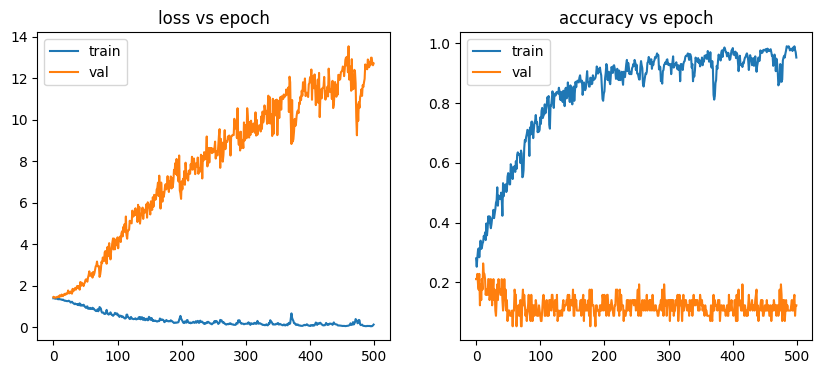

In [398]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(len(hist.history["loss"])), hist.history["loss"], label="train")
plt.plot(range(len(hist.history["val_loss"])), hist.history["val_loss"], label="val")
plt.title("loss vs epoch")
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(len(hist.history["accuracy"])), hist.history["accuracy"], label="train")
plt.plot(range(len(hist.history["val_accuracy"])), hist.history["val_accuracy"], label="val")
plt.title("accuracy vs epoch")
plt.legend()
plt.show()

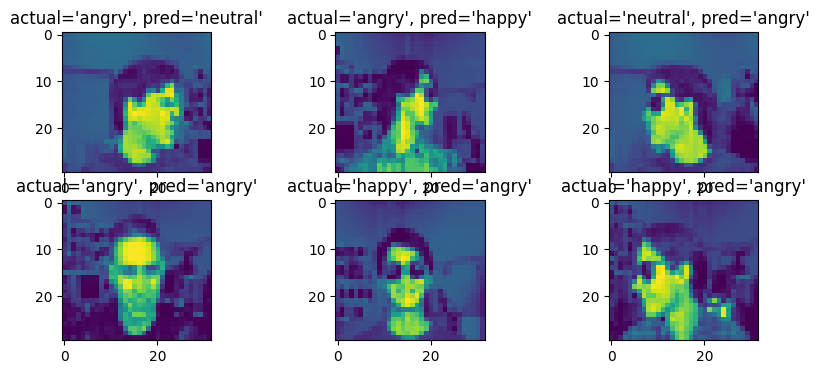

In [399]:
from random import sample
import math

plt.figure(figsize=(10, 4))
n_examples = 6
examples = sample(range(len(X_test)), k=n_examples)
for i in range(n_examples):
    x = X_test[i]
    y_actual = y_test[i]
    y_pred = model.predict(X_test[i].reshape(1, 30, 32), verbose=0)
    actual = le.inverse_transform([np.argmax(y_actual)])[0]
    pred = le.inverse_transform([np.argmax(y_pred)])[0]
    plt.subplot(2, math.ceil(n_examples/2), i+1)
    plt.imshow(x)
    plt.title(f"{actual=}, {pred=}")

plt.show()

### Tuned model for the Mood

In [402]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

le = LabelEncoder()
y = le.fit_transform(mood)

X_normalized = X / 255.0
num_classes = len(set(y))
y_categorical = to_categorical(y, num_classes)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_categorical, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(30, 32, 1)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


hist = model.fit(X_train, y_train, validation_data=[X_val, y_val], 
                 workers=-1, use_multiprocessing=True, epochs=500, verbose=0)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

2/2 [==============================] - 0s 3ms/step - loss: 15.0034 - accuracy: 0.1111
Loss: 15.003363609313965, Accuracy: 0.1111111119389534


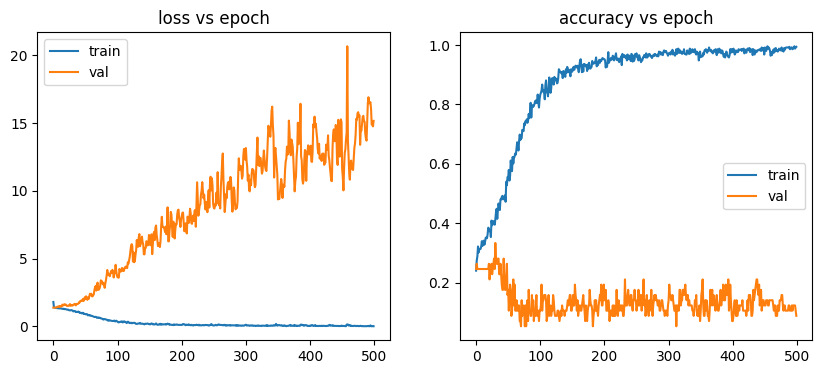

In [403]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(len(hist.history["loss"])), hist.history["loss"], label="train")
plt.plot(range(len(hist.history["val_loss"])), hist.history["val_loss"], label="val")
plt.title("loss vs epoch")
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(len(hist.history["accuracy"])), hist.history["accuracy"], label="train")
plt.plot(range(len(hist.history["val_accuracy"])), hist.history["val_accuracy"], label="val")
plt.title("accuracy vs epoch")
plt.legend()
plt.show()

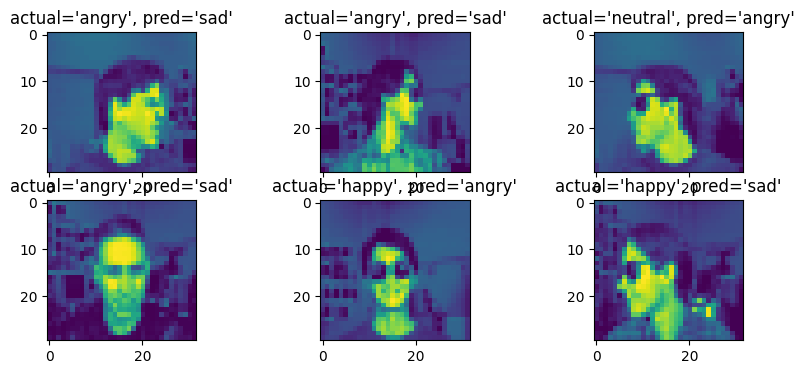

In [404]:
from random import sample
import math

plt.figure(figsize=(10, 4))
n_examples = 6
examples = sample(range(len(X_test)), k=n_examples)
for i in range(n_examples):
    x = X_test[i]
    y_actual = y_test[i]
    y_pred = model.predict(X_test[i].reshape(1, 30, 32), verbose=0)
    actual = le.inverse_transform([np.argmax(y_actual)])[0]
    pred = le.inverse_transform([np.argmax(y_pred)])[0]
    plt.subplot(2, math.ceil(n_examples/2), i+1)
    plt.imshow(x)
    plt.title(f"{actual=}, {pred=}")

plt.show()

Since this task is extremely hard even by a human, it's not weird to see the model struggle to correctly classify facial expressions in each image.